# Аналитика WHOOP: факторы восстановления, возрастные диапазоны и рекомендации

**Цель проекта** — определить, какие метрики (сон, нагрузка, HRV, пульс в покое и др.) сильнее всего связаны с высоким уровнем восстановления (`recovery_score`) и построить модель, которая предсказывает «хорошее восстановление».

**Что считаем «лучшим восстановлением»**: будем использовать бинарную метку `good_recovery` = 1, если `recovery_score ≥ 67` (условная «зелёная зона»), иначе 0.

**Дополнительные задачи**:
* посмотреть различия метрик и восстановления в возрастных группах;
* сформулировать практические рекомендации по улучшению сна и восстановления на основе результатов анализа.

> Примечание: датасет носит обучающий характер (похож на реальные метрики WHOOP). Методология полностью переносима на ваши реальные выгрузки, но конкретные числа могут отличаться.


In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (classification_report, roc_auc_score, RocCurveDisplay,
                             ConfusionMatrixDisplay, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Если установлен catboost — можно включить более сильную модель:
try:
    from catboost import CatBoostClassifier, Pool
    CATBOOST_AVAILABLE = True
except Exception:
    CATBOOST_AVAILABLE = False

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)


## Обзор и предобработка данных

Загрузим датасет и посмотрим структуру, пропуски и дубликаты.

In [2]:
data_path = "whoop_fitness_dataset_100k.csv"


df = pd.read_csv(data_path)
df.head()


,user_id,date,day_of_week,age,gender,weight_kg,height_cm,fitness_level,primary_sport,recovery_score,day_strain,sleep_hours,sleep_efficiency,sleep_performance,light_sleep_hours,rem_sleep_hours,deep_sleep_hours,wake_ups,time_to_fall_asleep_min,hrv,resting_heart_rate,hrv_baseline,rhr_baseline,respiratory_rate,skin_temp_deviation,calories_burned,workout_completed,activity_type,activity_duration_min,activity_strain,avg_heart_rate,max_heart_rate,activity_calories,hr_zone_1_min,hr_zone_2_min,hr_zone_3_min,hr_zone_4_min,hr_zone_5_min,workout_time_of_day
0,USER_00001,2023-01-01,Sunday,56,Female,53.9,167.2,Beginner,Weight Training,57.8,7.33,6.13,72.3,100.0,3.68,1.23,1.22,1,17.0,118.3,61.5,101,59,11.1,0.30,2849.0,0,Rest Day,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,USER_00001,2023-01-02,Monday,56,Female,53.9,167.2,Beginner,Weight Training,62.6,10.38,6.33,78.3,100.0,3.97,1.41,0.95,1,5.8,105.7,57.5,101,59,15.9,-0.37,3201.0,1,Weight Training,62,7.47,121.2,137.6,371.0,11.9,18.0,15.9,11.6,4.6,Evening
2,USER_00001,2023-01-03,Tuesday,56,Female,53.9,167.2,Beginner,Weight Training,81.5,7.16,6.17,78.8,100.0,3.70,1.52,0.95,0,5.0,95.3,56.7,101,59,14.9,-0.67,2697.0,0,Rest Day,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,USER_00001,2023-01-04,Wednesday,56,Female,53.9,167.2,Beginner,Weight Training,55.0,16.47,6.49,80.3,100.0,3.94,1.55,1.00,0,5.0,76.2,60.8,101,59,16.7,0.49,4175.0,0,Rest Day,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,USER_00001,2023-01-05,Thursday,56,Female,53.9,167.2,Beginner,Weight Training,62.5,16.67,6.67,73.0,100.0,4.14,1.49,1.04,0,5.0,94.4,65.6,101,59,16.7,1.69,4116.0,1,Weight Training,51,15.27,136.4,152.8,623.0,3.7,6.0,13.7,18.6,9.0,Evening


In [3]:
df.info()
print("Rows:", df.shape[0], "| Columns:", df.shape[1])
print("Unique users:", df['user_id'].nunique())
print("Duplicates:", df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_id                  100000 non-null  object 
 1   date                     100000 non-null  object 
 2   day_of_week              100000 non-null  object 
 3   age                      100000 non-null  int64  
 4   gender                   100000 non-null  object 
 5   weight_kg                100000 non-null  float64
 6   height_cm                100000 non-null  float64
 7   fitness_level            100000 non-null  object 
 8   primary_sport            100000 non-null  object 
 9   recovery_score           100000 non-null  float64
 10  day_strain               100000 non-null  float64
 11  sleep_hours              100000 non-null  float64
 12  sleep_efficiency         100000 non-null  float64
 13  sleep_performance        100000 non-null  float64
 14  light

In [4]:
na = df.isna().sum().sort_values(ascending=False)
na[na > 0].head(20)


workout_time_of_day    45990
dtype: int64

### Минимальная предобработка и фичи

Сделаем несколько полезных преобразований:
* `date` → datetime + `month`
* `workout_time_of_day`: пропуски заменим на `No workout`
* инженерные признаки относительно персонального базлайна:
  * `hrv_delta = hrv - hrv_baseline`
  * `rhr_delta = resting_heart_rate - rhr_baseline`
* целевая переменная:
  * `good_recovery = 1`, если `recovery_score ≥ 67`

Также проверим, есть ли константные столбцы (например, `sleep_performance` в этом датасете).

In [5]:
df = df.copy()
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

df['workout_time_of_day'] = df['workout_time_of_day'].fillna('No workout')

df['hrv_delta'] = df['hrv'] - df['hrv_baseline']
df['rhr_delta'] = df['resting_heart_rate'] - df['rhr_baseline']

df['good_recovery'] = (df['recovery_score'] >= 67).astype(int)

const_cols = df.columns[df.nunique(dropna=False) <= 1].tolist()
const_cols


['sleep_performance']

**Промежуточный вывод**

В этом датасете часто встречается константный признак `sleep_performance` (все значения = 100). Такие признаки не несут информации и их лучше исключать из моделей.

## Исследовательский анализ данных (EDA)

Посмотрим на распределения ключевых метрик и на связи с `recovery_score`.

### Гистограммы и распределения признаков

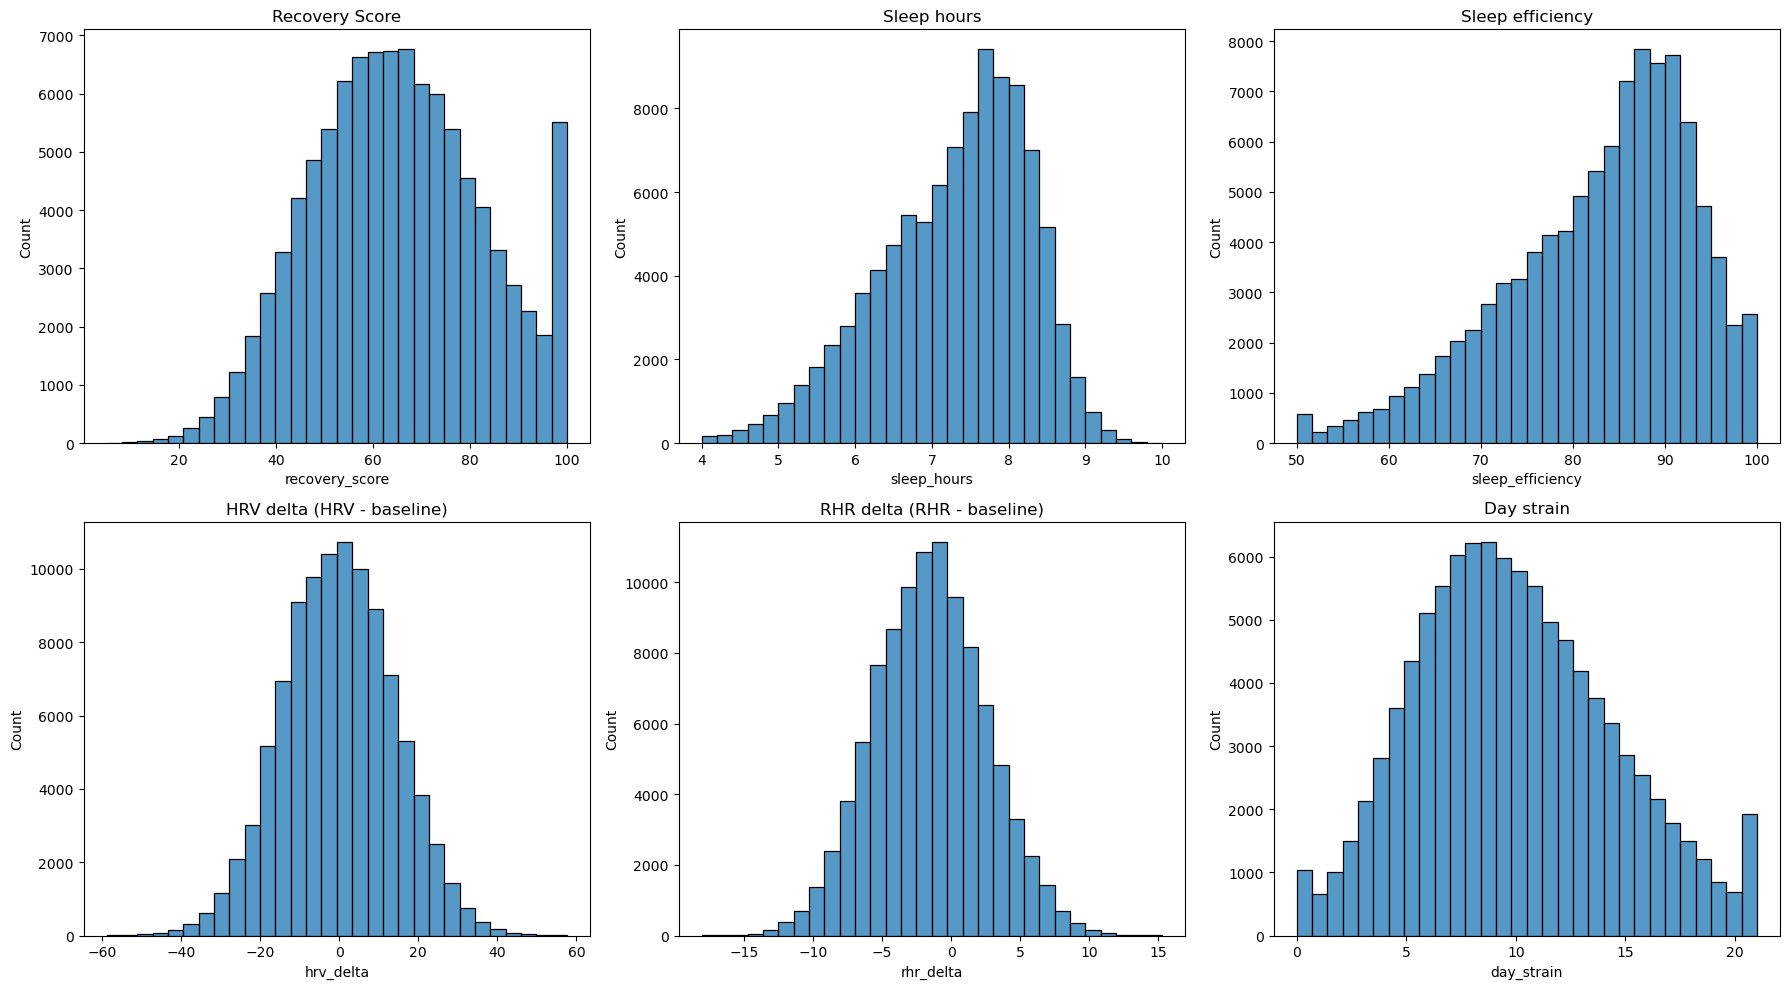

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.histplot(df['recovery_score'], bins=30, ax=axes[0,0])
axes[0,0].set_title('Recovery Score')

sns.histplot(df['sleep_hours'], bins=30, ax=axes[0,1])
axes[0,1].set_title('Sleep hours')

sns.histplot(df['sleep_efficiency'], bins=30, ax=axes[0,2])
axes[0,2].set_title('Sleep efficiency')

sns.histplot(df['hrv_delta'], bins=30, ax=axes[1,0])
axes[1,0].set_title('HRV delta (HRV - baseline)')

sns.histplot(df['rhr_delta'], bins=30, ax=axes[1,1])
axes[1,1].set_title('RHR delta (RHR - baseline)')

sns.histplot(df['day_strain'], bins=30, ax=axes[1,2])
axes[1,2].set_title('Day strain')

plt.tight_layout()
plt.show()


### Связь восстановления с HRV/RHR относительно базлайна

Ожидаемая гипотеза: **лучшее восстановление** связано с:
* **более высоким HRV**, особенно если он выше персонального базлайна;
* **более низким пульсом в покое**, особенно если он ниже персонального базлайна.

Проверим это на уровне простых корреляций.

In [7]:
corr_cols = [
    'recovery_score',
    'hrv', 'hrv_baseline', 'hrv_delta',
    'resting_heart_rate', 'rhr_baseline', 'rhr_delta',
    'sleep_hours', 'sleep_efficiency', 'wake_ups', 'time_to_fall_asleep_min',
    'day_strain', 'activity_strain', 'respiratory_rate', 'skin_temp_deviation'
]

corr = df[corr_cols].corr(numeric_only=True)['recovery_score'].sort_values(ascending=False)
corr


recovery_score             1.000000
hrv_delta                  0.349991
hrv                        0.188077
activity_strain            0.094230
day_strain                 0.034122
hrv_baseline               0.017817
sleep_hours                0.008242
respiratory_rate           0.006198
rhr_baseline               0.003163
skin_temp_deviation        0.002041
sleep_efficiency           0.002023
time_to_fall_asleep_min    0.000617
wake_ups                  -0.000244
resting_heart_rate        -0.176136
rhr_delta                 -0.409015
Name: recovery_score, dtype: float64

### Корреляционная матрица

Построим тепловую карту для числовых признаков (для удобства — только выбранные колонки).

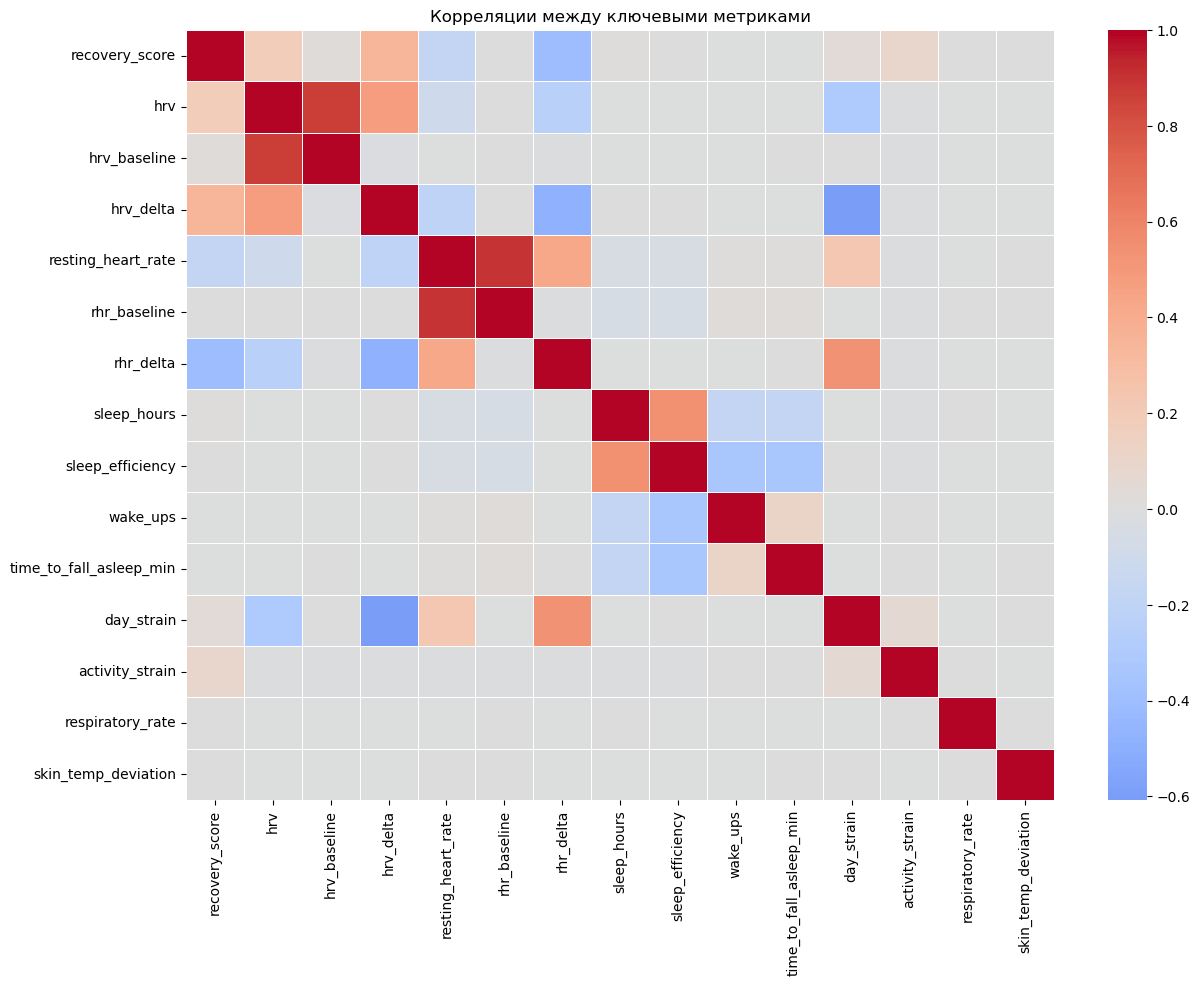

In [8]:
plt.figure(figsize=(14, 10))
sns.heatmap(df[corr_cols].corr(numeric_only=True), cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Корреляции между ключевыми метриками')
plt.show()


## Возрастные диапазоны

Сегментируем пользователей по возрасту и посмотрим:
* средний/медианный `recovery_score`
* долю «зелёного» восстановления (`good_recovery`)
* средние значения ключевых метрик (`hrv_delta`, `rhr_delta`, сон)


In [9]:
bins = [18, 25, 35, 45, 55, 65]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64']
df['age_group'] = pd.cut(df['age'], bins=bins, right=False, labels=labels)

age_stats = df.groupby('age_group', observed=True).agg(
    n=('recovery_score', 'size'),
    mean_recovery=('recovery_score', 'mean'),
    median_recovery=('recovery_score', 'median'),
    share_good=('good_recovery', 'mean'),
    mean_hrv_delta=('hrv_delta', 'mean'),
    mean_rhr_delta=('rhr_delta', 'mean'),
    mean_sleep=('sleep_hours', 'mean'),
    mean_wakeups=('wake_ups', 'mean'),
    mean_ttf=('time_to_fall_asleep_min', 'mean'),
).round(2)

age_stats


,n,mean_recovery,median_recovery,share_good,mean_hrv_delta,mean_rhr_delta,mean_sleep,mean_wakeups,mean_ttf
age_group,,,,,,,,,
18-24,11838,62.35,61.4,0.38,-0.64,-1.27,7.40,0.32,5.49
25-34,22725,65.01,64.4,0.45,-0.28,-1.48,7.38,0.32,5.53
35-44,21041,63.62,62.7,0.41,-0.54,-1.43,6.97,0.40,5.81
45-54,22115,66.01,65.5,0.47,0.17,-1.65,7.38,0.32,5.52
55-64,22281,67.29,66.8,0.50,0.42,-1.72,7.39,0.32,5.52


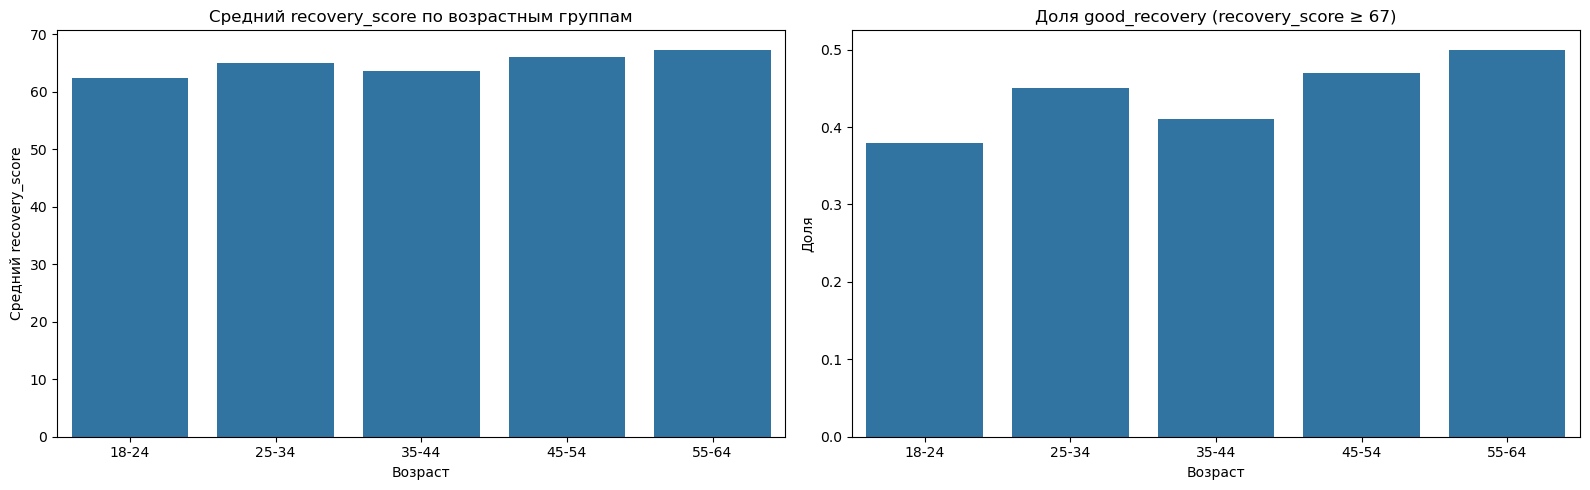

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.barplot(x=age_stats.index, y=age_stats['mean_recovery'], ax=axes[0])
axes[0].set_title('Средний recovery_score по возрастным группам')
axes[0].set_xlabel('Возраст')
axes[0].set_ylabel('Средний recovery_score')

sns.barplot(x=age_stats.index, y=age_stats['share_good'], ax=axes[1])
axes[1].set_title('Доля good_recovery (recovery_score ≥ 67)')
axes[1].set_xlabel('Возраст')
axes[1].set_ylabel('Доля')

plt.tight_layout()
plt.show()


### Насколько сильны эффекты HRV/RHR относительно базлайна?

Чтобы перевести корреляции в более «прикладной» формат, сравним средний `recovery_score`:
* в **нижнем квартиле** и **верхнем квартиле** `hrv_delta`
* в **лучшем квартиле** и **худшем квартиле** `rhr_delta`

Сделаем это для всего датасета и отдельно по возрастным группам.

In [11]:
df['hrv_delta_q'] = pd.qcut(df['hrv_delta'], 4, labels=['Q1_low', 'Q2', 'Q3', 'Q4_high'])
df['rhr_delta_q'] = pd.qcut(df['rhr_delta'], 4, labels=['Q1_lowest', 'Q2', 'Q3', 'Q4_highest'])

hrv_effect = df.groupby('hrv_delta_q', observed=True)['recovery_score'].mean().round(2)
rhr_effect = df.groupby('rhr_delta_q', observed=True)['recovery_score'].mean().round(2)

display(hrv_effect)
display(rhr_effect)


hrv_delta_q
Q1_low     57.70
Q2         62.63
Q3         66.69
Q4_high    73.59
Name: recovery_score, dtype: float64

rhr_delta_q
Q1_lowest     74.83
Q2            67.18
Q3            62.16
Q4_highest    56.21
Name: recovery_score, dtype: float64

In [12]:
# Возрастные группы: сравнение Q4 vs Q1
pivot_hrv = df[df['hrv_delta_q'].isin(['Q1_low','Q4_high'])].pivot_table(
    index='age_group', columns='hrv_delta_q', values='recovery_score', aggfunc='mean', observed=True
)
pivot_hrv['delta(Q4-Q1)'] = pivot_hrv['Q4_high'] - pivot_hrv['Q1_low']

pivot_rhr = df[df['rhr_delta_q'].isin(['Q1_lowest','Q4_highest'])].pivot_table(
    index='age_group', columns='rhr_delta_q', values='recovery_score', aggfunc='mean', observed=True
)
pivot_rhr['delta(Q1_lowest - Q4_highest)'] = pivot_rhr['Q1_lowest'] - pivot_rhr['Q4_highest']

display(pivot_hrv.round(1))
display(pivot_rhr.round(1))


hrv_delta_q,Q1_low,Q4_high,delta(Q4-Q1)
age_group,,,
18-24,55.4,70.2,14.8
25-34,57.5,73.9,16.4
35-44,56.4,72.5,16.1
45-54,58.6,74.2,15.6
55-64,59.7,75.3,15.6


rhr_delta_q,Q1_lowest,Q4_highest,delta(Q1_lowest - Q4_highest)
age_group,,,
18-24,72.3,54.4,17.9
25-34,74.8,56.5,18.3
35-44,73.9,54.5,19.4
45-54,75.1,56.9,18.2
55-64,76.5,58.0,18.5


## Модель прогнозирования восстановления

Цель моделирования: предсказать `good_recovery`.

Важный момент: в данных много записей на одного пользователя. Если случайно перемешать строки и разбить на train/test, одна и та же персона может попасть и туда, и туда — это даст завышенную оценку качества.

Поэтому используем **Group split по `user_id`** (обучаемся на одних пользователях, тестируемся на других).

### Про временную логику и утечки признаков (важно для реальных данных WHOOP)

В реальном WHOOP **Recovery обычно появляется утром** (после сна), а дневные метрики нагрузки (`day_strain`, тренировки и т.п.) формируются *в течение дня*.

Если мы пытаемся предсказывать утренний `recovery_score` **по признакам этого же дня**, можно случайно допустить утечку (использовать информацию из будущего).

Чтобы сделать постановку задачи более «жизненной», можно:
* использовать **сон этой ночи** (он уже известен утром) + **нагрузку вчерашнего дня** (lag-признаки);
* для проверки качества использовать **разбиение по пользователям** и/или по времени.

Ниже — пример, как создать лаг-признаки. Этот блок не обязателен, но рекомендуется, если вы хотите более корректный прогноз "утро → план нагрузки".

In [13]:
# Пример: создаём лаг-признаки по нагрузке (вчерашний день) для более корректного предсказания recovery "на утро"
df_lag = df.sort_values(['user_id','date']).copy()

lag_cols = [
    'day_strain', 'calories_burned',
    'workout_completed', 'activity_duration_min', 'activity_strain',
    'avg_heart_rate', 'max_heart_rate', 'activity_calories',
    'hr_zone_1_min', 'hr_zone_2_min', 'hr_zone_3_min', 'hr_zone_4_min', 'hr_zone_5_min'
]

for col in lag_cols:
    if col in df_lag.columns:
        df_lag[col + '_prev'] = df_lag.groupby('user_id')[col].shift(1)

# Первое наблюдение каждого пользователя будет с NaN в lag-признаках — его можно удалить
df_lag = df_lag.dropna(subset=[c + '_prev' for c in lag_cols if c in df.columns])

df_lag[['user_id','date'] + [c + '_prev' for c in ['day_strain','activity_strain']]].head()


,user_id,date,day_strain_prev,activity_strain_prev
1,USER_00001,2023-01-02,7.33,0.00
2,USER_00001,2023-01-03,10.38,7.47
3,USER_00001,2023-01-04,7.16,0.00
4,USER_00001,2023-01-05,16.47,0.00
5,USER_00001,2023-01-06,16.67,15.27


In [14]:
target = 'good_recovery'
group_col = 'user_id'

drop_cols = ['recovery_score', 'sleep_performance', 'date', 'age_group', 'hrv_delta_q', 'rhr_delta_q']
X = df.drop(columns=[target] + [c for c in drop_cols if c in df.columns])
y = df[target]
groups = df[group_col]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

X_train.shape, X_test.shape


((79583, 39), (20417, 39))

### Логистическая регрессия (базовая модель)

Чтобы модель обучалась быстро и давала интерпретируемые коэффициенты, возьмём только числовые признаки + закодируем `gender`.

Это **бэйзлайн**, который удобно интерпретировать.

In [15]:
# Базовый набор признаков для интерпретируемой модели
baseline_features = [
    'age', 'weight_kg', 'height_cm',
    'sleep_hours', 'sleep_efficiency', 'wake_ups', 'time_to_fall_asleep_min',
    'day_strain', 'activity_strain',
    'hrv', 'hrv_baseline', 'hrv_delta',
    'resting_heart_rate', 'rhr_baseline', 'rhr_delta',
    'respiratory_rate', 'skin_temp_deviation'
]

# gender: простое кодирование
Xb_train = X_train[baseline_features + ['gender']].copy()
Xb_test = X_test[baseline_features + ['gender']].copy()

Xb_train['gender'] = Xb_train['gender'].map({'Male': 1, 'Female': 0})
Xb_test['gender'] = Xb_test['gender'].map({'Male': 1, 'Female': 0})

# Масштабирование числовых признаков
scaler = StandardScaler()
Xb_train_scaled = scaler.fit_transform(Xb_train)
Xb_test_scaled = scaler.transform(Xb_test)

lr = LogisticRegression(max_iter=2000)
lr.fit(Xb_train_scaled, y_train)

proba_lr = lr.predict_proba(Xb_test_scaled)[:, 1]
pred_lr = (proba_lr >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, proba_lr).round(3))
print(classification_report(y_test, pred_lr))


ROC-AUC: 0.791
              precision    recall  f1-score   support

           0       0.75      0.78      0.76     11678
           1       0.69      0.65      0.67      8739

    accuracy                           0.72     20417
   macro avg       0.72      0.71      0.72     20417
weighted avg       0.72      0.72      0.72     20417



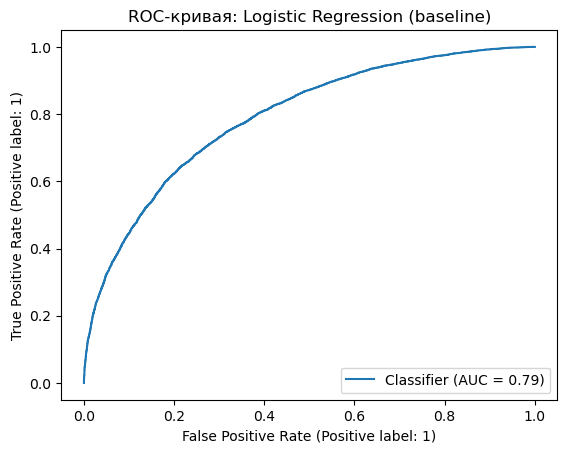

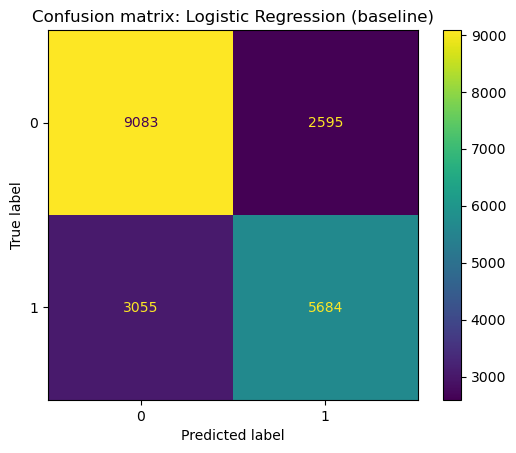

In [16]:
# ROC-кривая и матрица ошибок
RocCurveDisplay.from_predictions(y_test, proba_lr)
plt.title("ROC-кривая: Logistic Regression (baseline)")
plt.show()

cm = confusion_matrix(y_test, pred_lr)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion matrix: Logistic Regression (baseline)")
plt.show()


#### Интерпретация коэффициентов (какие метрики двигают вероятность good_recovery)

Знак коэффициента показывает направление связи: положительный — увеличивает вероятность `good_recovery`, отрицательный — снижает.

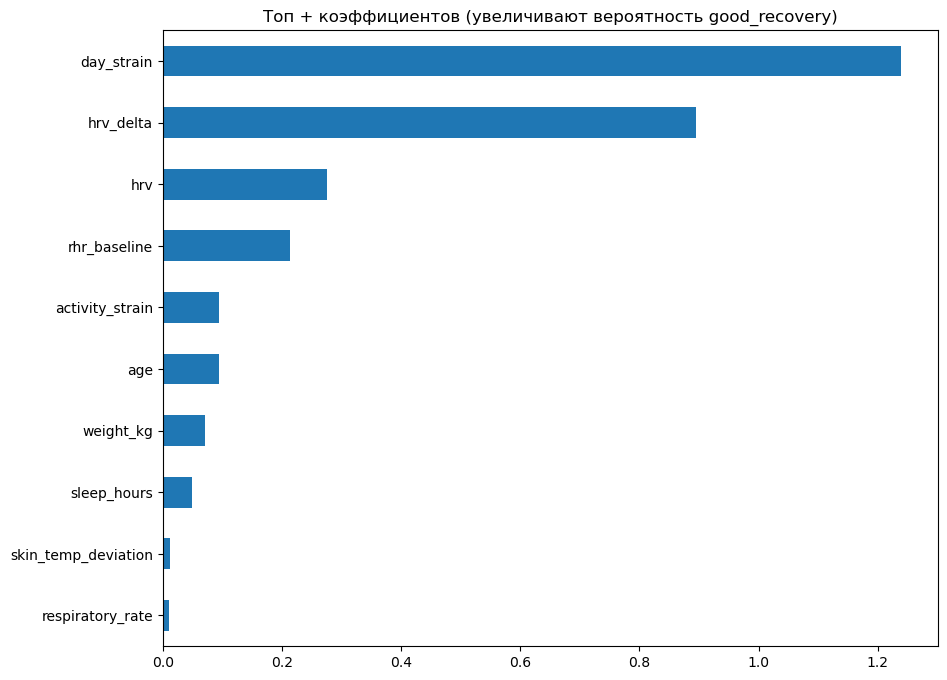

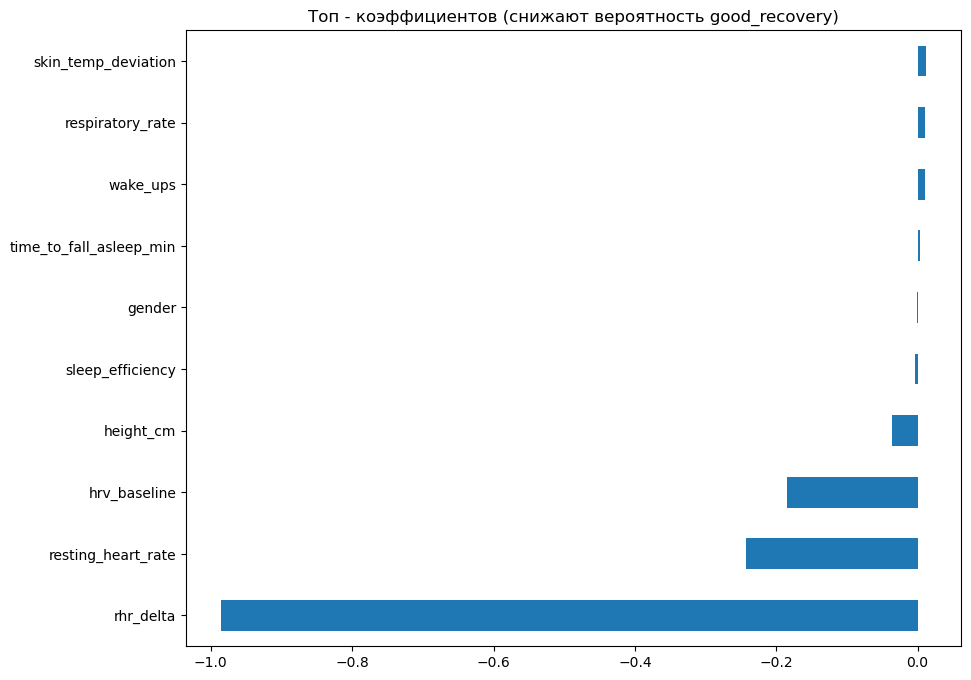

In [17]:
coef = pd.Series(lr.coef_[0], index=Xb_train.columns)
coef_sorted = coef.sort_values()

plt.figure(figsize=(10, 8))
coef_sorted.tail(10).plot(kind='barh')
plt.title("Топ + коэффициентов (увеличивают вероятность good_recovery)")
plt.show()

plt.figure(figsize=(10, 8))
coef_sorted.head(10).plot(kind='barh')
plt.title("Топ - коэффициентов (снижают вероятность good_recovery)")
plt.show()


### Случайный лес (нелинейная модель)

Случайный лес поможет поймать нелинейности и взаимодействия признаков. Для скорости — используем тот же набор признаков, что и в базовой модели.

In [18]:
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    max_depth=10,
    min_samples_leaf=15
)
rf.fit(Xb_train, y_train)

proba_rf = rf.predict_proba(Xb_test)[:, 1]
pred_rf = (proba_rf >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, proba_rf).round(3))
print(classification_report(y_test, pred_rf))


ROC-AUC: 0.775
              precision    recall  f1-score   support

           0       0.73      0.78      0.76     11678
           1       0.68      0.62      0.65      8739

    accuracy                           0.71     20417
   macro avg       0.71      0.70      0.70     20417
weighted avg       0.71      0.71      0.71     20417



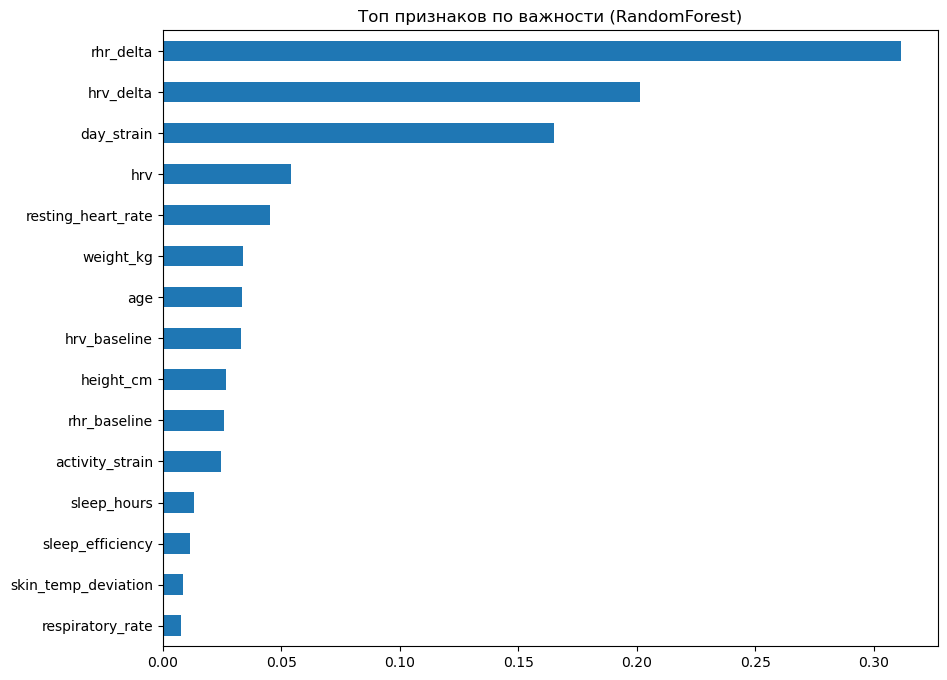

In [19]:
# Важность признаков (RandomForest)
imp = pd.Series(rf.feature_importances_, index=Xb_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
imp.head(15).sort_values().plot(kind='barh')
plt.title("Топ признаков по важности (RandomForest)")
plt.show()


### (Опционально) CatBoost на всех признаках

Если установлен `catboost`, можно обучить модель на *всех* признаках, включая категориальные (`fitness_level`, `primary_sport`, `activity_type` и т.д.) без one-hot.

На больших данных CatBoost часто даёт качество выше, чем RandomForest.

In [20]:
if CATBOOST_AVAILABLE:
    full_features = [c for c in X_train.columns if c not in [group_col]]
    cat_cols = ['day_of_week','gender','fitness_level','primary_sport','activity_type','workout_time_of_day']
    cat_indices = [X_train[full_features].columns.get_loc(c) for c in cat_cols if c in full_features]

    train_pool = Pool(X_train[full_features], y_train, cat_features=cat_indices)
    test_pool = Pool(X_test[full_features], y_test, cat_features=cat_indices)

    cb = CatBoostClassifier(
        iterations=300,
        depth=6,
        learning_rate=0.08,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        verbose=50
    )
    cb.fit(train_pool, eval_set=test_pool, use_best_model=True)

    proba_cb = cb.predict_proba(test_pool)[:, 1]
    pred_cb = (proba_cb >= 0.5).astype(int)

    print("ROC-AUC:", roc_auc_score(y_test, proba_cb).round(3))
    print(classification_report(y_test, pred_cb))

    # Важность признаков
    fi = pd.Series(cb.get_feature_importance(train_pool), index=X_train[full_features].columns).sort_values(ascending=False)
    display(fi.head(20))
else:
    print("catboost не установлен — пропускаем этот блок")


0:	test: 0.7362685	best: 0.7362685 (0)	total: 86.6ms	remaining: 25.9s
50:	test: 0.7876930	best: 0.7876930 (50)	total: 1.17s	remaining: 5.69s
100:	test: 0.7870177	best: 0.7890703 (58)	total: 2.22s	remaining: 4.38s
150:	test: 0.7828676	best: 0.7890703 (58)	total: 3.29s	remaining: 3.25s
200:	test: 0.7819451	best: 0.7890703 (58)	total: 4.4s	remaining: 2.17s
250:	test: 0.7795246	best: 0.7890703 (58)	total: 5.48s	remaining: 1.07s
299:	test: 0.7786001	best: 0.7890703 (58)	total: 6.55s	remaining: 0us

bestTest = 0.7890703339
bestIteration = 58

Shrink model to first 59 iterations.
ROC-AUC: 0.789
              precision    recall  f1-score   support

           0       0.74      0.79      0.76     11678
           1       0.69      0.64      0.66      8739

    accuracy                           0.72     20417
   macro avg       0.72      0.71      0.71     20417
weighted avg       0.72      0.72      0.72     20417



rhr_delta                25.092810
hrv_delta                23.595593
day_strain               22.214559
weight_kg                 5.274903
age                       4.690124
calories_burned           4.367169
hrv_baseline              3.052973
primary_sport             3.001643
height_cm                 2.757426
fitness_level             1.722788
hrv                       0.858001
rhr_baseline              0.843060
activity_strain           0.824518
month                     0.528244
hr_zone_1_min             0.272764
activity_calories         0.256273
activity_duration_min     0.251319
rem_sleep_hours           0.126065
hr_zone_5_min             0.109738
hr_zone_4_min             0.063543
dtype: float64

## Кластеризация (профили пользователей)

Добавим сегментацию: сгруппируем пользователей по их **средним** метрикам и посмотрим, какие «профили» дают лучшее восстановление.

Идея: агрегируем данные по `user_id` → стандартизируем признаки → KMeans.

In [24]:
user_df = df.groupby('user_id').agg({
    'age':'first',
    'gender':'first',
    'fitness_level':'first',
    'recovery_score':'mean',
    'sleep_hours':'mean',
    'sleep_efficiency':'mean',
    'wake_ups':'mean',
    'time_to_fall_asleep_min':'mean',
    'day_strain':'mean',
    'activity_strain':'mean',
    'hrv':'mean',
    'resting_heart_rate':'mean',
    'hrv_delta':'mean',
    'rhr_delta':'mean',
    'respiratory_rate':'mean'
}).reset_index()

user_df.head(20)


,user_id,age,gender,fitness_level,recovery_score,sleep_hours,sleep_efficiency,wake_ups,time_to_fall_asleep_min,day_strain,activity_strain,hrv,resting_heart_rate,hrv_delta,rhr_delta,respiratory_rate
0,USER_00001,56,Female,Beginner,73.412074,6.009071,70.819505,0.588235,6.708669,10.008731,3.987368,103.201858,56.774613,2.201858,-2.225387,16.126316
1,USER_00002,56,Male,Elite,54.032362,5.929256,70.426214,0.514563,6.875405,9.387249,9.225663,78.057282,47.487379,-2.942718,-0.512621,15.886408
2,USER_00003,43,Male,Intermediate,75.655077,6.023908,69.853538,0.600000,6.164923,10.293815,3.786338,62.820615,53.464000,1.820615,-2.536000,15.990769
3,USER_00004,36,Male,Advanced,65.308833,8.015426,90.084858,0.195584,5.042271,9.711546,8.843091,87.085804,58.261199,0.085804,-1.738801,15.844164
4,USER_00005,47,Female,Intermediate,65.152351,7.016050,80.439498,0.291536,5.625705,9.860878,4.702382,57.353605,53.290596,0.353605,-1.709404,15.963950
5,USER_00006,55,Male,Intermediate,65.441803,5.996557,68.782240,0.606557,6.661749,9.485820,4.687104,33.275956,72.189617,2.275956,-1.810383,16.070765
6,USER_00007,29,Female,Intermediate,63.854875,8.069526,89.834540,0.233983,5.112813,9.813955,2.965738,78.280780,60.635933,-0.719220,-1.364067,15.937883
7,USER_00008,61,Female,Intermediate,64.073563,7.985862,90.157184,0.212644,5.119253,9.608218,2.456839,38.770402,70.512069,0.770402,-1.487931,16.148851
8,USER_00009,63,Male,Beginner,64.609769,7.984344,90.160154,0.223650,5.104627,10.043702,4.987378,32.962982,57.602828,-0.037018,-1.397172,16.055013
9,USER_00010,61,Female,Advanced,64.750255,6.034923,69.810204,0.612245,6.593622,9.883699,5.063597,90.581122,57.764541,-1.418878,-1.235459,15.977551


In [32]:
from sklearn.cluster import KMeans

cluster_features = [
    'age', 'sleep_hours', 'sleep_efficiency', 'wake_ups', 'time_to_fall_asleep_min',
    'day_strain', 'activity_strain', 'hrv', 'resting_heart_rate', 'hrv_delta', 'rhr_delta', 'respiratory_rate'
]

scaler_cl = StandardScaler()
X_cl = scaler_cl.fit_transform(user_df[cluster_features])

k = 4
km = KMeans(n_clusters=k, random_state=42, n_init=10)
user_df['cluster'] = km.fit_predict(X_cl)


cluster_summary = user_df.groupby('cluster').agg(
    size=('user_id','size'),
    mean_age=('age','mean'),
    mean_recovery=('recovery_score','mean'),
    mean_sleep=('sleep_hours','mean'),
    mean_eff=('sleep_efficiency','mean'),
    mean_wakeups=('wake_ups','mean'),
    mean_ttf=('time_to_fall_asleep_min','mean'),
    mean_strain=('day_strain','mean'),
    mean_hrv_delta=('hrv_delta','mean'),
    mean_rhr_delta=('rhr_delta','mean'),
    mean_rhr=('resting_heart_rate','mean')
).round(2).sort_values('mean_recovery', ascending=False)

cluster_summary

,size,mean_age,mean_recovery,mean_sleep,mean_eff,mean_wakeups,mean_ttf,mean_strain,mean_hrv_delta,mean_rhr_delta,mean_rhr
cluster,,,,,,,,,,,
3,89,44.42,70.54,8.0,89.96,0.20,5.13,9.95,1.42,-2.05,56.57
1,76,41.68,70.07,7.0,79.88,0.40,5.70,9.97,1.31,-2.02,57.64
0,47,42.04,64.53,6.0,69.93,0.60,6.58,9.92,-0.42,-1.45,58.06
2,74,38.03,54.03,7.6,85.89,0.28,5.34,9.80,-3.21,-0.49,58.67


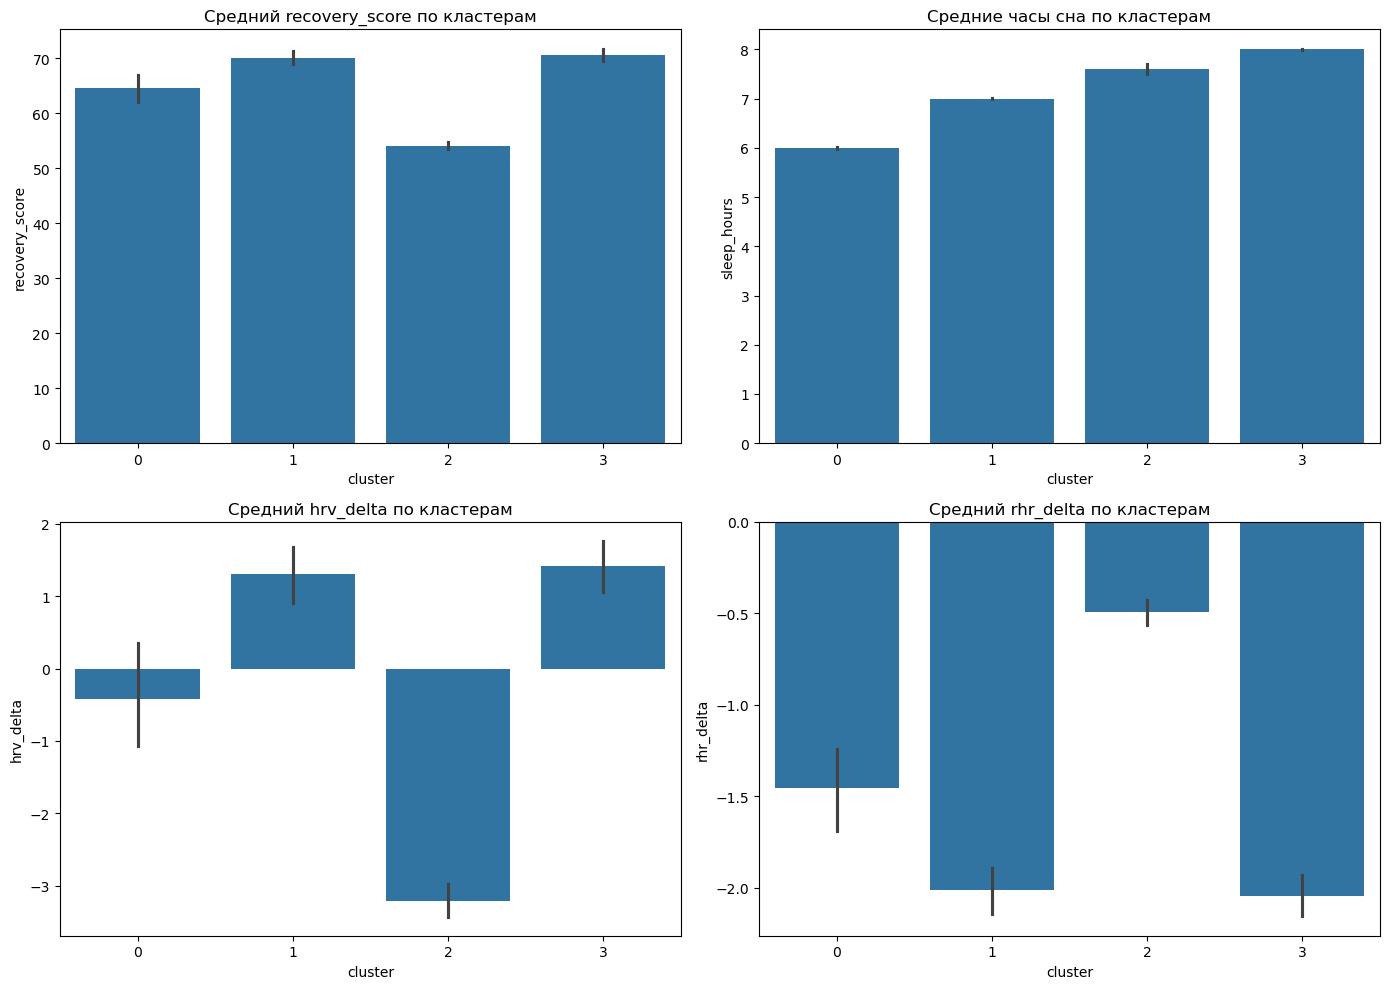

In [29]:
# Визуально: recovery vs sleep vs HRV/RHR deltas по кластерам
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.barplot(data=user_df, x='cluster', y='recovery_score', ax=axes[0,0])
axes[0,0].set_title('Средний recovery_score по кластерам')

sns.barplot(data=user_df, x='cluster', y='sleep_hours', ax=axes[0,1])
axes[0,1].set_title('Средние часы сна по кластерам')

sns.barplot(data=user_df, x='cluster', y='hrv_delta', ax=axes[1,0])
axes[1,0].set_title('Средний hrv_delta по кластерам')

sns.barplot(data=user_df, x='cluster', y='rhr_delta', ax=axes[1,1])
axes[1,1].set_title('Средний rhr_delta по кластерам')

plt.tight_layout()
plt.show()


## Выводы и рекомендации

**1.** Мы построили пайплайн анализа и предобработки данных WHOOP и выделили целевой признак `good_recovery`.

**2.** Самые сильные связи с восстановлением в датасете — это отклонения от базлайна:
* `hrv_delta = hrv - hrv_baseline` — чем выше HRV относительно базлайна, тем выше восстановление;
* `rhr_delta = resting_heart_rate - rhr_baseline` — чем ниже пульс в покое относительно базлайна, тем выше восстановление.

**3.** Возрастные группы отличаются по среднему восстановлению и доле `good_recovery`, но **направление ключевых факторов одинаковое**: HRV↑ (выше базлайна) и RHR↓ (ниже базлайна) практически во всех группах ассоциированы с лучшим восстановлением.

**4.** Мы обучили модели (логистическая регрессия как интерпретируемый бэйзлайн и RandomForest как нелинейную модель) и получили ранжирование факторов.

**5.** Сегментация пользователей (кластеризация) помогает выделить профили:
* «высокое восстановление» — обычно сочетание хороших `hrv_delta` и `rhr_delta` + стабильного сна;
* «низкое восстановление» — чаще связано с плохими отклонениями HRV/RHR от базлайна даже при неплохих часах сна.

---
### Практические рекомендации (что делать, чтобы чаще попадать в good recovery)

Рекомендации привязаны к метрикам, которые вы видите в WHOOP:

**Если падает HRV (особенно ниже базлайна):**
* снизьте интенсивность тренировок на 24–48 часов (активное восстановление вместо HIIT);
* уделите внимание стресс-менеджменту (дыхательные практики/медитация/прогулки);
* проверьте сон: длительность и регулярность; 
* пересмотрите алкоголь и поздний кофеин (часто бьют по HRV).

**Если растёт RHR (выше базлайна):**
* это может быть маркером недовосстановления, инфекции, обезвоживания или перетренированности — сделайте «лёгкий день»;
* обеспечьте гидратацию и питание (особенно после высокой нагрузки);
* проверьте, не стало ли хуже качество сна (частые пробуждения, поздний отход ко сну).

**Если проблема в сне (sleep_hours/efficiency, wake_ups, time_to_fall_asleep):**
* фиксированное время подъёма и отхода ко сну;
* минимум яркого света и экранов за 60–90 минут до сна;
* прохладная, тёмная и тихая спальня;
* кофеин — не позднее середины дня (индивидуально);
* если регулярно много пробуждений/храп/сонливость днём — стоит обсудить с врачом.

> Это не медицинская рекомендация. Если показатели резко ухудшились или есть симптомы (одышка, боль, сильная усталость), лучше обратиться к специалисту.
